In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available:  0
2.4.1


In [3]:
# Set parameters here 
INPUT_SIZE = 256
BATCH_SIZE = 64

SEED = 12345
np.random.seed(SEED)

path = r'E:/work/data/101_ObjectCategories'
classes = os.listdir(path)
myclasses = classes
myclasses.remove('BACKGROUND_Google')
myclasses.remove('Faces')

NUMCLASSES = len(myclasses)

mapping = {}
for i in range(NUMCLASSES):
    mapping[i] = myclasses[i]


In [4]:
from skimage import exposure

def preprocess(img):
    # Contrast stretching
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    
    return img_rescale


In [5]:
train_datagen = ImageDataGenerator(
                                featurewise_center=False,
                                samplewise_center=True,
                                featurewise_std_normalization=False,
                                samplewise_std_normalization=True,
                                zca_epsilon=1e-06,
                                rotation_range=5,
                                width_shift_range=0.05,
                                height_shift_range=0.05,
                                brightness_range=None,
                                shear_range=0.5,
                                zoom_range=0.05,
                                channel_shift_range=0.0,
                                fill_mode="nearest",
                                cval=0.0,
                                horizontal_flip=False,
                                vertical_flip=False,
                                rescale=1./255,
                                preprocessing_function=None,#preprocess,
                                data_format=None,
                                validation_split=0.2,
                                dtype=None,
                            )


In [6]:
# Make a dtaframe with all the file paths and labels
allfilelist = []
alllabels = []
alllabels_word = []
for i in range(NUMCLASSES):
    filepath = path + '/' + myclasses[i]
    filelist = os.listdir(filepath)
    for f in filelist:
        if f.lower() == 'thumbs.db':
            continue
        
        fullpath = filepath + '/' + f
        allfilelist.append(fullpath)
        alllabels.append(i)
        alllabels_word.append(myclasses[i])
        
d = {'filename':allfilelist,'labelnum':alllabels,'label':alllabels_word}

df = pd.DataFrame(d)
df.tail()
    


,filename,labelnum,label
8237,E:/work/data/101_ObjectCategories/yin_yang/ima...,99,yin_yang
8238,E:/work/data/101_ObjectCategories/yin_yang/ima...,99,yin_yang
8239,E:/work/data/101_ObjectCategories/yin_yang/ima...,99,yin_yang
8240,E:/work/data/101_ObjectCategories/yin_yang/ima...,99,yin_yang
8241,E:/work/data/101_ObjectCategories/yin_yang/ima...,99,yin_yang


In [7]:
# This next line is to use only some x% of the data
df = df.sample(frac=0.25)
df.head()

,filename,labelnum,label
7711,E:/work/data/101_ObjectCategories/umbrella/ima...,92,umbrella
1572,E:/work/data/101_ObjectCategories/camera/image...,13,camera
1531,E:/work/data/101_ObjectCategories/butterfly/im...,12,butterfly
8044,E:/work/data/101_ObjectCategories/wheelchair/i...,95,wheelchair
7602,E:/work/data/101_ObjectCategories/trilobite/im...,91,trilobite


In [8]:
print(df['label'].value_counts())

Motorbikes    200
airplanes     190
Faces_easy    113
watch          67
Leopards       45
             ... 
scissors        6
tick            5
pigeon          5
gerenuk         4
strawberry      4
Name: label, Length: 100, dtype: int64


In [9]:


training_set = train_datagen.flow_from_dataframe(
                                            dataframe=df,
                                            directory='',
                                            x_col="filename",
                                            y_col="label",
                                            #weight_col=None,
                                            target_size=(INPUT_SIZE, INPUT_SIZE),
                                            color_mode="rgb",
                                            classes=None,
                                            class_mode="categorical",
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            seed=None,
                                            save_to_dir=None,
                                            save_prefix="",
                                            save_format="png",
                                            subset='training',
                                            interpolation="nearest",
                                            #validate_filenames=True
                                        )

validation_set = train_datagen.flow_from_dataframe( dataframe=df,
                                            directory='',
                                            x_col="filename",
                                            y_col="label",
                                            #weight_col=None,
                                            target_size=(INPUT_SIZE, INPUT_SIZE),
                                            color_mode="rgb",
                                            classes=None,
                                            class_mode="categorical",
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            seed=None,
                                            save_to_dir=None,
                                            save_prefix="",
                                            save_format="png",
                                            subset='validation',
                                            interpolation="nearest",
                                            #validate_filenames=True
                                            )

Found 1648 validated image filenames belonging to 100 classes.
Found 412 validated image filenames belonging to 100 classes.


In [10]:

#from sklearn.model_selection import train_test_split
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

model = Sequential()

model.add(InputLayer(input_shape=[INPUT_SIZE,INPUT_SIZE,3])) #keras will internally add batch dimension

model.add(Conv2D(filters=32,kernel_size=3,strides=1,padding='same', activation='relu'))
model.add(Conv2D(filters=32,kernel_size=3,strides=1,padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2,padding='same'))
model.add(Dropout(0.4))

model.add(Conv2D(filters=64,kernel_size=3,strides=1,padding='same', activation='relu'))
model.add(Conv2D(filters=64,kernel_size=3,strides=1,padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2,padding='same'))
model.add(Dropout(0.4))

model.add(Conv2D(filters=128,kernel_size=3,strides=1,padding='same', activation='relu'))
model.add(Conv2D(filters=128,kernel_size=3,strides=1,padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2,padding='same'))
model.add(Dropout(0.4))


model.add(Flatten())


model.add(Dense(256,activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(NUMCLASSES,activation='softmax'))


model.compile(optimizer=Adam(lr=0.00001), loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0

In [11]:
#Training

for epoch in range(0,50):
    print("Epoch",epoch)
    if epoch != 0:
        # Load Model Weights
        model.load_weights('model-normalized-aug.h5')    
    history = model.fit(training_set,
    steps_per_epoch=len(training_set),
                   epochs=1,
                   validation_data=validation_set,
                   validation_steps = len(validation_set))

    model.save_weights("model-normalized-aug.h5")
    print("Saved model to disk after",epoch+1,"epochs.")


Epoch 0
26/26 [==============================] - 279s 11s/step - loss: 4.5610 - accuracy: 0.0501 - val_loss: 4.5294 - val_accuracy: 0.1408
Saved model to disk after 1 epochs.
Epoch 1
26/26 [==============================] - 349s 14s/step - loss: 4.4141 - accuracy: 0.1092 - val_loss: 4.4923 - val_accuracy: 0.1214
Saved model to disk after 2 epochs.
Epoch 2
26/26 [==============================] - 323s 12s/step - loss: 4.3879 - accuracy: 0.1110 - val_loss: 4.4658 - val_accuracy: 0.1481
Saved model to disk after 3 epochs.
Epoch 3
26/26 [==============================] - 328s 13s/step - loss: 4.3212 - accuracy: 0.1280 - val_loss: 4.4372 - val_accuracy: 0.1505
Saved model to disk after 4 epochs.
Epoch 4
26/26 [==============================] - 326s 13s/step - loss: 4.2546 - accuracy: 0.1371 - val_loss: 4.3833 - val_accuracy: 0.1650
Saved model to disk after 5 epochs.
Epoch 5
26/26 [==============================] - 311s 12s/step - loss: 4.2138 - accuracy: 0.1468 - val_loss: 4.3502 - val_acc

In [12]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

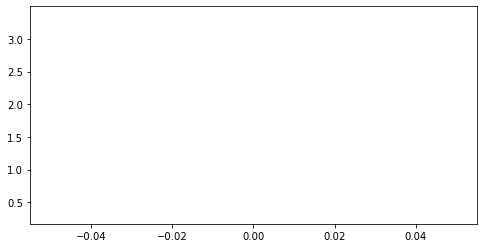

In [14]:
fig = plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],color='red')
plt.plot(history.history['accuracy'],color='green')
plt.plot(history.history['val_loss'],color='magenta')
plt.plot(history.history['val_accuracy'],color='blue')
plt.show()

(1, 256, 256, 3)
Output Probabilities: [0.01229235 0.01486774 0.01205168 0.00808192 0.03266202 0.01531616
 0.01156494 0.01142007 0.0126514  0.00839752 0.00899005 0.0077503
 0.01763529 0.00535833 0.01013649 0.01211441 0.00919361 0.00544779
 0.01346949 0.00389405 0.00918902 0.00587571 0.00665739 0.01165723
 0.00612204 0.0074906  0.00977594 0.00714757 0.01186932 0.00494946
 0.00463977 0.00757804 0.01636607 0.00540313 0.0072713  0.00879109
 0.01008174 0.01113487 0.01206744 0.00702454 0.00840404 0.00561099
 0.00437738 0.00854881 0.00899886 0.0097579  0.0354779  0.01050107
 0.00576098 0.01963023 0.00681344 0.00622923 0.00925729 0.01051585
 0.01754443 0.00817279 0.00628808 0.01487436 0.00919033 0.00779033
 0.00780704 0.00806694 0.00984004 0.01282739 0.01301198 0.0094072
 0.01132505 0.00836977 0.0105881  0.00841463 0.00651096 0.00836114
 0.01417755 0.01525705 0.014582   0.00711518 0.00534757 0.02495393
 0.01356439 0.0138044  0.00965449 0.01113465 0.01051938 0.00589446
 0.00698723 0.0141576  0.

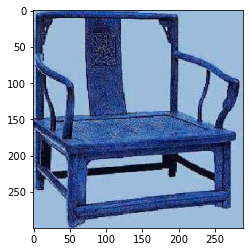

In [34]:
# Get random image
classnum = np.random.randint(NUMCLASSES)
folder = path + '/' + myclasses[classnum]
filelist = os.listdir(folder)
i = np.random.randint(len(filelist))
while filelist[i].lower()=='thumbs.db':
    i = np.random.randint(len(filelist))
image_path = folder + '/' + filelist[i]
image = cv2.imread(image_path)
plt.imshow(image)

# Prepare image
img = tf.keras.preprocessing.image.load_img(image_path)
img = tf.keras.preprocessing.image.img_to_array(img)
#img = preprocess(img)
img = cv2.resize(img,(INPUT_SIZE,INPUT_SIZE))
img_tensor = np.expand_dims(img, axis=0)
img_tensor /= 255.

# Print what the top predicted class is
print(img_tensor.shape)
preds = model.predict(img_tensor,steps=1)
preds = preds.flatten()
print("Output Probabilities:", preds)
order = np.argsort(preds)
order = order[::-1]
print('Predictions:')
for i in range(5):
    if preds[order[i]] == 0:
        break
    else:
        print(myclasses[order[i]], ':', preds[order[i]])
